In [1]:
# importing packages and data

import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

df = pd.read_csv("extended_data.csv", 
dtype={0: float, 1: str, 2: float,  3: float,  4: float,  5: float,  6: float,  7: float,  8: int}
)

# fill missed funding periods with 0
df["funding"] = df["funding"].fillna(0)

# check number of assets
print(len(df["asset"].unique()))

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

57
Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate]
Index: []


In [2]:
# define constants
RETURNS_LOOKBACK = 30
TARGET_VOLATILITY = 1/math.sqrt(365)
print(TARGET_VOLATILITY)

0.052342392259021375


In [3]:
# making time readable
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# getting returns and return and funding volatility

# asset retuns
df["returns"] = (
    df.groupby("asset")["close"]
      .transform(lambda x: x.pct_change())
)

# asset returns inclusive of funding
df["returns_funding"] = df["returns"] - df["funding"]

# next day asset returns inclusive of funding
df["next_returns_funding"] = (
    df.groupby("asset")["returns_funding"]
      .shift(-1)
)

# asset returns and funding volatility
df["rolling_returns_funding_vol"] = (
    df.groupby("asset")["returns_funding"]
      .rolling(window=RETURNS_LOOKBACK)
      .std()
      .reset_index(level=0, drop=True)
)

# check work
df.iloc[50:56].head()

,timestamp,asset,open,high,low,close,volume,funding,funding inaccurate,returns,returns_funding,next_returns_funding,rolling_returns_funding_vol
50,2025-01-25 20:00:00,1000BONK-USD,0.029637,0.029813,0.028716,0.029260,574900.0,-0.000037,24,-0.012721,-0.012684,-0.154063,0.075372
51,2025-01-26 20:00:00,1000BONK-USD,0.029260,0.029260,0.024299,0.024748,1239300.0,-0.000141,24,-0.154204,-0.154063,0.008947,0.080323
52,2025-01-27 20:00:00,1000BONK-USD,0.024748,0.026785,0.024748,0.024954,982400.0,-0.000623,24,0.008324,0.008947,-0.001621,0.079880
53,2025-01-28 20:00:00,1000BONK-USD,0.024954,0.025741,0.022771,0.024913,1317900.0,-0.000022,24,-0.001643,-0.001621,0.014194,0.079750
54,2025-01-29 20:00:00,1000BONK-USD,0.024913,0.026438,0.023934,0.025254,1091300.0,-0.000506,24,0.013688,0.014194,-0.012058,0.079690


In [4]:
# creating funding signal
df["funding_sig"] = np.log(df["funding"]+1)

In [5]:
# scaling returns and funding by volatility
df["returns_funding_volscaled"] = df["returns_funding"]*(TARGET_VOLATILITY/df["rolling_returns_funding_vol"])

# next day asset returns and funding scaled by volatility
df["next_returns_funding_volscaled"] = (
    df.groupby("asset")["returns_funding_volscaled"]
      .shift(-1)
)

# editing to remove what wont yet include a volatility scale and final day
df = df[df.groupby('asset').cumcount() > 30].copy()
df = df.groupby('asset').head(-1).copy()

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate, returns, returns_funding, next_returns_funding, rolling_returns_funding_vol, funding_sig, returns_funding_volscaled, next_returns_funding_volscaled]
Index: []


In [6]:
idx_max = df["next_returns_funding_volscaled"].idxmax()
print(df.loc[idx_max])
idx_min = df["next_returns_funding_volscaled"].idxmin()
print(df.loc[idx_min])

timestamp                         2025-02-28 20:00:00
asset                                         ADA-USD
open                                            0.636
high                                           0.6517
low                                            0.6282
close                                          0.6424
volume                                         1560.0
funding                                     -0.000301
funding inaccurate                                 24
returns                                      0.010063
returns_funding                              0.010364
next_returns_funding                         0.620888
rolling_returns_funding_vol                  0.042673
funding_sig                                 -0.000301
returns_funding_volscaled                    0.012712
next_returns_funding_volscaled               0.264183
Name: 1439, dtype: object
timestamp                         2025-06-16 20:00:00
asset                                          IP-USD
op

In [7]:
# create funding deciles
df['funding_decile'] = df.groupby('timestamp')['funding_sig'] \
        .transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))

# check df
unique_times = df["timestamp"].unique()
#print(unique_times)
print(df[df["timestamp"] == unique_times[0]])

                timestamp         asset           open           high  \
31    2025-01-06 20:00:00  1000BONK-USD       0.035732       0.036173   
447   2025-01-06 20:00:00  1000PEPE-USD       0.020988       0.021022   
737   2025-01-06 20:00:00  1000SHIB-USD       0.024243       0.024266   
1386  2025-01-06 20:00:00       ADA-USD       1.112000       1.148700   
1827  2025-01-06 20:00:00       ARB-USD       0.927300       0.931000   
2246  2025-01-06 20:00:00      AVAX-USD      44.330000      44.520000   
2884  2025-01-06 20:00:00       BNB-USD     731.800000     745.600000   
3307  2025-01-06 20:00:00       BTC-USD  101786.100000  102639.100000   
3755  2025-01-06 20:00:00      DOGE-USD       0.386630       0.397920   
4450  2025-01-06 20:00:00       ETH-USD    3691.920000    3702.950000   
4996  2025-01-06 20:00:00      GOAT-USD       0.519000       0.522000   
6726  2025-01-06 20:00:00      LINK-USD      23.897000      24.009000   
7132  2025-01-06 20:00:00       LTC-USD     114.970

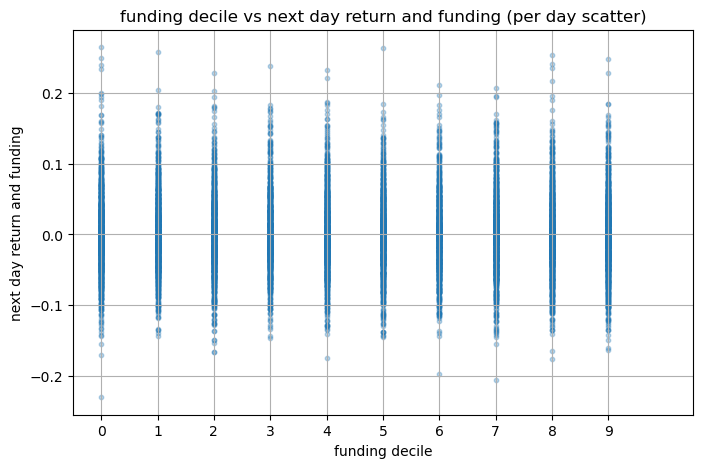

In [8]:
# scatter plot to gain initial intuiton

plt.figure(figsize=(8,5))
plt.scatter(
    df["funding_decile"], 
    df["next_returns_funding_volscaled"], 
    alpha=0.3, 
    s=10
)

plt.xlabel("funding decile")
plt.ylabel("next day return and funding")
plt.title("funding decile vs next day return and funding (per day scatter)")
plt.grid(True)

plt.xlim(-0.5, 10.5)
plt.xticks(range(0, 10))
plt.show()

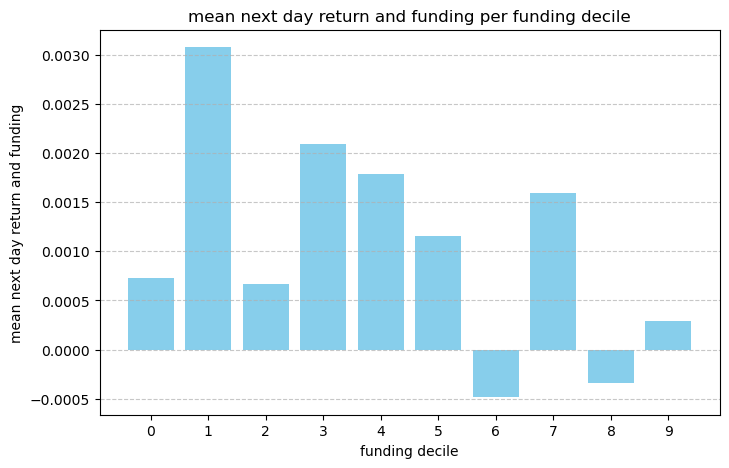

In [9]:
# decile plot to aim to see effects more clearly
decile_means = df.groupby("funding_decile")["next_returns_funding_volscaled"].mean()

plt.figure(figsize=(8,5))
plt.bar(decile_means.index, decile_means.values, color="skyblue")
plt.xlabel("funding decile")
plt.ylabel("mean next day return and funding")
plt.title("mean next day return and funding per funding decile")
plt.xticks(decile_means.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()